# Analyzing Survey Data

There are a lot of different tools and methods to analyze survey data.  Most survey tools have built in analysis capabilities that work to a varying degree.  Qualtrics has spent a lot of efort in this area because it is a major pain point.  

Regradless of this effort, many people still have a manual process that involves a variety of different tools.  The net result for most analysis is a PowerPoint deck with the summary of the results an commenary and recommendations.

To start closing the loop and since we don't have the data in any specific system, we will be using Python to analyze the survey data.  This will give us one additional chance to explore the way that Python can be used in data science.

`Note: It is possible to analyze survey data in Excel and many people are sucessful at doing that.  The way it works makes it difficult however.  As a general purpose graphical tool it makes something easier, but a lot of things much harder.`

## Analysis Steps

The basic steps that you will want to go through when analyzing data are:

1. Download the data and convert to a format appropriate for the software you will be using - We want a .csv file for Python
2. Read in the data file and manually check to make sure that the process is working as expected
3. Recode the data - This is especially important for missing and N/A data
4. Clean the data - Generally removing entire records when the responses of the respondents are questionable
5. (Optional) Weight Data - This step greatly complicates the further analysis so it is often skipped in cases where the data is approximately representative
6. Run Cross Tabulations (crosstabs) to summarize the data and compare and contrast questions - many people have a script run all possible crosstabs
7. Prepare visualizations to explore data and start to plan for the visualization necessary in the final report
8. Perform any necessary statistical testing (This step is often not preformed.  If you are stat testing crosstabs the appropriate test is a chi-squared test)
9. Prepare presentation - This might be in collaboration with the internal or external client, but the analyst will almost always be involved in the process

## Download data

This step will depend heavily on the software system you are using.  If you decided to go with a third part survey programming and hosting service the third part will handle this for you.  This is what happened for our survey.

When you get the survey data from a third party make sure you get a copy of the survey as it was programmed.  It is common that there are last minute changes to the questions and wording.  Unless you are militant about maintaining the survey document it will not match the programmed survey and you will not know what you are analyzing.

Many survey programs will provide a print out of the survey designed for the analysis stage.  This can be a helpful backup if you were not faithful about maintaining the original survey document.

# Read in data file

This should be straight forward as it is like using any other data file


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [12]:
# Read in data
data = pd.read_csv('https://raw.githubusercontent.com/statuser/MBA656AWebsite/master/Survey%20Data%20Example/DigitalCamera_030413.csv', parse_dates=[1, 2])

In [18]:
data.head()

,ID,StartTime,EndTime,ILength,SurveyVersion,S1_1,S1_2,S1_3,S1_4,S1_5,...,D4_3,D4_4,D4_5,D5,D6,D7,D8,D9,GlossaryTime,DCTime
0,13040668,2013-02-28 13:56:00,2013-02-28 14:08:00,703,1,0,0,0,0,0,...,0,0,0,2,4,1,2,47404,61,174
1,13040669,2013-02-28 13:56:00,2013-02-28 14:01:00,302,1,0,0,0,0,0,...,0,0,0,2,3,2,9,75219,54,92
2,13040673,2013-02-28 13:56:00,2013-02-28 14:00:00,235,1,0,0,0,0,0,...,0,0,0,2,1,3,1,17601,35,56
3,13040675,2013-02-28 13:56:00,2013-02-28 14:15:00,1109,1,0,0,0,0,0,...,0,0,0,2,4,1,5,60657,39,955
4,13040676,2013-02-28 13:56:00,2013-02-28 14:17:00,1244,1,0,0,0,0,0,...,0,0,0,2,3,3,1,62522,640,63


## Code Data

The purpose of coding the data is putting it into a format that is easy for you as the analysis to understand.

The first step is to make sure that the missing and N/A values are coded correctly.  In .csv files the standard it to just leave the value blank.  This signals to the software that this is a missing value.  Other pacakages however will use a `.`, `-`, or a `NA`.  You want to make sure that this is in a format that you can actually use.

The second step is to translate categorical values stored as numbers to labels that are meaningful for analysis.  It gets really annoying to constantly be looking up, "What does 3 mean for this question?"  You will want to supply the substitutions up front.

In Python you will want to use the Pandas categorical data type for this. (https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html)

In [21]:
# Code Data

data["Gender"] = data["D1"].astype('category')
data["Gender"] = data["Gender"].cat.rename_categories(['Male', 'Female'])
data["Gender"]

Female    1927
Male      1084
Name: Gender, dtype: int64

In [22]:
data["Age"] = 2020 - data["D2"]

max(data["Age"])

80

In [23]:

min(data["Age"])

25

<AxesSubplot:ylabel='Frequency'>

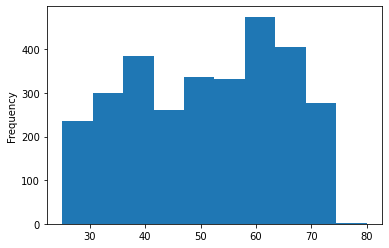

In [24]:
data["Age"].plot.hist()

In [25]:
# 25 - 80 What groups do we want?
labels = ["18 - 35", "36 - 50", "51 - 65", "65+"]
data["AgeGroups"] = pd.cut(data["Age"], bins=[18, 35, 50, 65, 100], labels=labels)
data["AgeGroups"].value_counts()

51 - 65    1101
36 - 50     876
18 - 35     536
65+         498
Name: AgeGroups, dtype: int64

<AxesSubplot:>

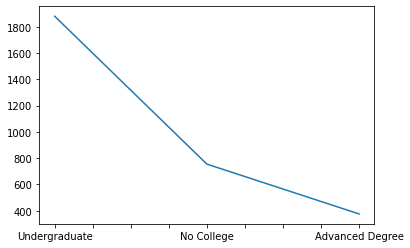

In [29]:
data["Education"] = data["D6"]
data.loc[data["Education"] == 2, "Education"] = 1

data.loc[data["Education"] == 3, "Education"] = 2
data.loc[data["Education"] == 4, "Education"] = 2
data.loc[data["Education"] == 5, "Education"] = 3
data.loc[data["Education"] == 6, "Education"] = 3
data["Education"] = data["Education"].astype('category').cat.rename_categories(['No College',
                                                                                'Undergraduate',
                                                                                'Advanced Degree'])
data["Education"].value_counts().plot()

## Clean the data

Cleaning the data usually means ensuring that all the respondents included in your survey were attentive and provided answers that were reasinable.  This is a hard step because it requires making judgements about who to remove and who not to remove.  There is a the potential for introducing bias into your data if you are too agressive about cleaning respondent out.  Almost always if ther eis a problem with a resppondent you will remove their entire record.

__Always do this on a copy of your data file not on the original!__ You want to be able to 1) go back to the original file and 2) document the steps that you took in case you need to justify or revisit the cleanign procedure.  I like to do the cleaning in code for this reason.  Code always is complete and tells the truth.

When cleaning data there are three major categories of bad responses that you will want to look at:
1. Check for missing data
2. Check for straightliners/christmas tree responses
3. Check for speeeders

In [36]:
data

,ID,StartTime,EndTime,ILength,SurveyVersion,S1_1,S1_2,S1_3,S1_4,S1_5,...,D6,D7,D8,D9,GlossaryTime,DCTime,Gender,Age,AgeGroups,Education
0,13040668,2013-02-28 13:56:00,2013-02-28 14:08:00,703,1,0,0,0,0,0,...,4,1,2,47404,61,174,Male,55,51 - 65,Undergraduate
1,13040669,2013-02-28 13:56:00,2013-02-28 14:01:00,302,1,0,0,0,0,0,...,3,2,9,75219,54,92,Male,33,18 - 35,Undergraduate
2,13040673,2013-02-28 13:56:00,2013-02-28 14:00:00,235,1,0,0,0,0,0,...,1,3,1,17601,35,56,Female,29,18 - 35,No College
3,13040675,2013-02-28 13:56:00,2013-02-28 14:15:00,1109,1,0,0,0,0,0,...,4,1,5,60657,39,955,Male,65,51 - 65,Undergraduate
4,13040676,2013-02-28 13:56:00,2013-02-28 14:17:00,1244,1,0,0,0,0,0,...,3,3,1,62522,640,63,Female,55,51 - 65,Undergraduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,13049156,2013-03-01 18:26:00,2013-03-01 18:29:00,202,1,0,0,0,0,0,...,3,5,1,12525,15,55,Male,56,51 - 65,Undergraduate
3007,13049159,2013-03-01 18:26:00,2013-03-01 18:33:00,457,1,0,0,0,0,0,...,4,5,6,49048,95,158,Male,67,65+,Undergraduate
3008,13049169,2013-03-01 18:26:00,2013-03-01 18:36:00,585,1,0,0,0,0,0,...,4,3,1,77073,134,260,Female,68,65+,Undergraduate
3009,13049202,2013-03-01 18:30:00,2013-03-01 18:40:00,611,1,0,0,0,0,0,...,4,1,3,35242,75,312,Male,36,36 - 50,Undergraduate


In [37]:
# Clean Data
# Remove respondents who say that they don't have an electronic device, but do have a camera???

data = data[data["T1_7"] == 0]


data


,ID,StartTime,EndTime,ILength,SurveyVersion,S1_1,S1_2,S1_3,S1_4,S1_5,...,D6,D7,D8,D9,GlossaryTime,DCTime,Gender,Age,AgeGroups,Education
0,13040668,2013-02-28 13:56:00,2013-02-28 14:08:00,703,1,0,0,0,0,0,...,4,1,2,47404,61,174,Male,55,51 - 65,Undergraduate
1,13040669,2013-02-28 13:56:00,2013-02-28 14:01:00,302,1,0,0,0,0,0,...,3,2,9,75219,54,92,Male,33,18 - 35,Undergraduate
2,13040673,2013-02-28 13:56:00,2013-02-28 14:00:00,235,1,0,0,0,0,0,...,1,3,1,17601,35,56,Female,29,18 - 35,No College
3,13040675,2013-02-28 13:56:00,2013-02-28 14:15:00,1109,1,0,0,0,0,0,...,4,1,5,60657,39,955,Male,65,51 - 65,Undergraduate
4,13040676,2013-02-28 13:56:00,2013-02-28 14:17:00,1244,1,0,0,0,0,0,...,3,3,1,62522,640,63,Female,55,51 - 65,Undergraduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,13049156,2013-03-01 18:26:00,2013-03-01 18:29:00,202,1,0,0,0,0,0,...,3,5,1,12525,15,55,Male,56,51 - 65,Undergraduate
3007,13049159,2013-03-01 18:26:00,2013-03-01 18:33:00,457,1,0,0,0,0,0,...,4,5,6,49048,95,158,Male,67,65+,Undergraduate
3008,13049169,2013-03-01 18:26:00,2013-03-01 18:36:00,585,1,0,0,0,0,0,...,4,3,1,77073,134,260,Female,68,65+,Undergraduate
3009,13049202,2013-03-01 18:30:00,2013-03-01 18:40:00,611,1,0,0,0,0,0,...,4,1,3,35242,75,312,Male,36,36 - 50,Undergraduate


In [38]:
# Check for straight lining
# This looks across multiple questions to see if the variance is 0.0.  It the variance is 0.0 then the respondents
# answered the same for 16 straight questions
data = data[data.loc[:, ["DC_{col}".format(col=i) for i in range(1, 17)]].var(axis=1) != 0.0]
data

,ID,StartTime,EndTime,ILength,SurveyVersion,S1_1,S1_2,S1_3,S1_4,S1_5,...,D6,D7,D8,D9,GlossaryTime,DCTime,Gender,Age,AgeGroups,Education
0,13040668,2013-02-28 13:56:00,2013-02-28 14:08:00,703,1,0,0,0,0,0,...,4,1,2,47404,61,174,Male,55,51 - 65,Undergraduate
1,13040669,2013-02-28 13:56:00,2013-02-28 14:01:00,302,1,0,0,0,0,0,...,3,2,9,75219,54,92,Male,33,18 - 35,Undergraduate
2,13040673,2013-02-28 13:56:00,2013-02-28 14:00:00,235,1,0,0,0,0,0,...,1,3,1,17601,35,56,Female,29,18 - 35,No College
3,13040675,2013-02-28 13:56:00,2013-02-28 14:15:00,1109,1,0,0,0,0,0,...,4,1,5,60657,39,955,Male,65,51 - 65,Undergraduate
4,13040676,2013-02-28 13:56:00,2013-02-28 14:17:00,1244,1,0,0,0,0,0,...,3,3,1,62522,640,63,Female,55,51 - 65,Undergraduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,13049156,2013-03-01 18:26:00,2013-03-01 18:29:00,202,1,0,0,0,0,0,...,3,5,1,12525,15,55,Male,56,51 - 65,Undergraduate
3007,13049159,2013-03-01 18:26:00,2013-03-01 18:33:00,457,1,0,0,0,0,0,...,4,5,6,49048,95,158,Male,67,65+,Undergraduate
3008,13049169,2013-03-01 18:26:00,2013-03-01 18:36:00,585,1,0,0,0,0,0,...,4,3,1,77073,134,260,Female,68,65+,Undergraduate
3009,13049202,2013-03-01 18:30:00,2013-03-01 18:40:00,611,1,0,0,0,0,0,...,4,1,3,35242,75,312,Male,36,36 - 50,Undergraduate


<AxesSubplot:ylabel='Frequency'>

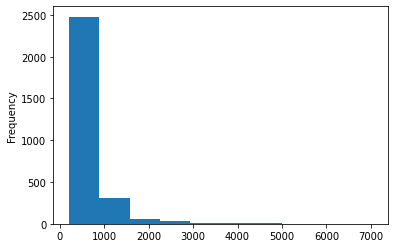

In [40]:
data["ILength"].plot.hist()

In [47]:
data["ILength"].quantile(0.05)

235.0

In [48]:
# Check for speeding


data = data[data["ILength"] > data["ILength"].quantile(0.05)]
data

,ID,StartTime,EndTime,ILength,SurveyVersion,S1_1,S1_2,S1_3,S1_4,S1_5,...,D6,D7,D8,D9,GlossaryTime,DCTime,Gender,Age,AgeGroups,Education
0,13040668,2013-02-28 13:56:00,2013-02-28 14:08:00,703,1,0,0,0,0,0,...,4,1,2,47404,61,174,Male,55,51 - 65,Undergraduate
1,13040669,2013-02-28 13:56:00,2013-02-28 14:01:00,302,1,0,0,0,0,0,...,3,2,9,75219,54,92,Male,33,18 - 35,Undergraduate
3,13040675,2013-02-28 13:56:00,2013-02-28 14:15:00,1109,1,0,0,0,0,0,...,4,1,5,60657,39,955,Male,65,51 - 65,Undergraduate
4,13040676,2013-02-28 13:56:00,2013-02-28 14:17:00,1244,1,0,0,0,0,0,...,3,3,1,62522,640,63,Female,55,51 - 65,Undergraduate
5,13040677,2013-02-28 13:56:00,2013-02-28 14:02:00,360,1,0,0,0,0,0,...,4,3,3,55045,71,127,Male,44,36 - 50,Undergraduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,13049150,2013-03-01 18:25:00,2013-03-01 18:31:00,360,1,0,0,0,0,0,...,6,5,1,95826,65,131,Female,71,65+,Advanced Degree
3007,13049159,2013-03-01 18:26:00,2013-03-01 18:33:00,457,1,0,0,0,0,0,...,4,5,6,49048,95,158,Male,67,65+,Undergraduate
3008,13049169,2013-03-01 18:26:00,2013-03-01 18:36:00,585,1,0,0,0,0,0,...,4,3,1,77073,134,260,Female,68,65+,Undergraduate
3009,13049202,2013-03-01 18:30:00,2013-03-01 18:40:00,611,1,0,0,0,0,0,...,4,1,3,35242,75,312,Male,36,36 - 50,Undergraduate


## Weight the data

This topic is too complicated to cover in this class.  It is best to avoid the issue by ensuring the sample is properly balanced using quotas and careful sample selection.  If you are in a situation where you need to weight your data it is best to have professional help from somebody that has experience in this area.  

When you weight the data you will be influencing all the subsequent analysis and will need to account for that weighting especially if you do any statistical testing.

## Crosstabs

Crosstabs is a a contraction of crosstabulations and is used to refer to counting up the responses in a set of categories.  Strictly it refers to comparing two separate questions or variables, but in practice it refers to any counting summary. You will often want to prepare crosstabs for all your questions and a broad selection of question pairs.  This is the primary output that you will analyze to compare and contrast the results.

If you have properly coded your data this step is very easy to handle as there are builtin tools to create the crosstabs.

In [49]:
# Compute Cross tabs

data["Gender"].value_counts()

Female    1776
Male       987
Name: Gender, dtype: int64

In [55]:
pd.crosstab(data["Education"], data["Gender"], normalize='columns')

Gender,Male,Female
Education,,
No College,0.221884,0.264640
Undergraduate,0.636272,0.620495
Advanced Degree,0.141844,0.114865


## Exploratory Visualizations

When you create visualizations at this step you are primarily using them to explore the data rather than preparing presentation quality reports.

The primary visualizations you will use are:
- Bar Charts
- Histograms
- Occasionally scatter plots

You generally will not be creating line charts because you don't have data over time in a survey.

Pay attention to the difference between proportions and raw counts.  Each one has it's uses, but you need to be aware and intentional about which one you use.


## Statistical Testing 

How much testing you do is going to be dependent on your organization, audience, and data.  This is something that we haven't covered heavily in this class, but it is worth investigating.  Most people that I work with outsource statistical testing to an expert because there are some subtle nuances that are difficut to keep track of if you don't do it regularly and don't have extensive training.

## Prepare final report

This is something that you are all probably better at than I am since you get extensive practice doing this in the MBA program.